### Mercari Price 
The files consist of a list of product listings. These files are tab-delimited.

Fields:
- train_id or test_id - the id of the listing

- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid  leakage. These removed prices are represented as [rm]

- item_condition_id - the condition of the items provided by the seller

- category_name - category of the listing

- brand_name

- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

- shipping - 1 if shipping fee is paid by seller and 0 by buyer

- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

## Setup

In [1]:
! pip install pydot graphviz emoji transformers

import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K


from tqdm._tqdm_notebook import tqdm_notebook

import os
import itertools

import matplotlib.pyplot as plt
import itertools
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Flatten, Dropout, LSTM, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from nltk.corpus import stopwords
import string

import pickle

from tensorflow.keras.preprocessing.text import text_to_word_sequence 
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import TweetTokenizer

import emoji
import os

from sklearn.feature_extraction.text import CountVectorizer

import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, pipeline

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))
stop_words.remove("no")

tqdm_notebook.pandas()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  app.launch_new_instance()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return K.sqrt(msle(y_true, y_pred))

## Colab

In [3]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

# check if in colab
if RunningInCOLAB and not os.path.isdir('/content/gdrive'):
    print("Running in colab")
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    colab_root = '/content/drive'
      
if RunningInCOLAB:
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'project-mercari-price/'
    if not os.path.isdir(base_dir):
        os.mkdir(base_dir)
else:
    root_dir= os.getcwd()
    base_dir = root_dir

os.chdir(base_dir)

os.getcwd()

'/content/gdrive/My Drive/project-mercari-price'

## Dataset download

In [4]:
dataset_downloaded_path = os.path.join(base_dir, "dataset_downloaded.ignore")
dataset_downloaded = os.path.isfile(dataset_downloaded_path)
dataset_downloaded

if not dataset_downloaded:
  # install kaggle to download dataset
  ! pip install kaggle python-dotenv

# set to True if you want to save kaggle credentials into a .env file
persist_credentials = False

if not dataset_downloaded:
  # create .env file containing KAGGLE_USER and KAGGLE_KEY
    kaggle_env = os.path.join(base_dir, '.env')
    if not os.path.isfile(kaggle_env):
        with open(kaggle_env, 'w') as envfile:
            kaggle_user = input("Insert kaggle username")
            kaggle_key = input("Insert kaggle key; generate one from kaggle account")
        if persist_credentials:
            envfile.write(f"""
            KAGGLE_USERNAME={kaggle_user}
            KAGGLE_KEY={kaggle_key}
            """)

        # set env vars
        os.environ["KAGGLE_USERNAME"] = kaggle_user
        os.environ["KAGGLE_KEY"] = kaggle_key

        del kaggle_user
        del kaggle_key

if not dataset_downloaded:
  # loading env vars if .env file exists
    if os.path.isfile(kaggle_env):
        from dotenv import load_dotenv
        load_dotenv(dotenv_path=kaggle_env)
    print(os.environ.get("KAGGLE_USERNAME"))

if not dataset_downloaded:
    # download and extract dataset
    ! kaggle competitions download -c mercari-price-suggestion-challenge

    # create file so that we know we already downloaded
    with open(dataset_downloaded_path, 'w') as dd_file:
        dataset_downloaded = True
        dd_file.write("")

    print('cwd: ', os.getcwd())
    
    os.listdir()

if not dataset_downloaded:
    ! 7z x train.tsv.7z
    ! 7z x test.tsv.7z

os.listdir()

['train.tsv',
 'test.tsv',
 '.env',
 'dataset_downloaded.ignore',
 'Untitled0.ipynb',
 'MercariPrice1_old.ipynb',
 'MercariPrice_old.ipynb',
 'train_preprocess.npy',
 'test_preprocess.npy',
 'model.png',
 'MercariPrice1.ipynb']

## Load dataset

In [5]:
dtypes={
    'name': 'string',
    'item_condition_id': 'int32',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'int32',
    'item_description': 'string'
}
data = pd.read_csv("train.tsv", sep='\t', dtype=dtypes)
data = data.drop(columns=["train_id"])
print(data.dtypes)
print(data.shape)
data

name                  string
item_condition_id      int32
category_name         string
brand_name            string
price                float64
shipping               int32
item_description      string
dtype: object
(1482535, 7)


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,<NA>,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,<NA>,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,<NA>,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,<NA>,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,<NA>,45.0,1,There is 2 of each one that you see! So 2 red ...


In [6]:
dtypes={
    'name': 'string',
    'item_condition_id': 'int32',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'int32',
    'item_description': 'string'
}
test = pd.read_csv("test.tsv", sep='\t', dtype=dtypes)
test = test.drop(columns=["test_id"])
print(test.dtypes)
print(test.shape)
test

name                 string
item_condition_id     int32
category_name        string
brand_name           string
shipping              int32
item_description     string
dtype: object
(693359, 6)


,name,item_condition_id,category_name,brand_name,shipping,item_description
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,<NA>,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,<NA>,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,<NA>,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,<NA>,1,Rediscovering life after the loss of a loved o...
...,...,...,...,...,...,...
693354,Quartz crystal on Flint stone,1,Home/Home Décor/Home Décor Accents,<NA>,0,Flint/Quartz cluster. Self mined ✨measures 3x2...
693355,It Cosmetics - Travel Bundle,1,Beauty/Makeup/Makeup Sets,IT Cosmetics,1,It Cosmetics travel bundle. Includes: Brow pow...
693356,Galaxy S8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",<NA>,1,New. Free shipping Basstop case
693357,Hi low floral kimono,2,Women/Swimwear/Cover-Ups,<NA>,0,Floral kimono. Tropical print. Open front. Hi ...


In [6]:
for column in data.columns:
    print("number of null value in {} : {}".format(column,data[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 6327
number of null value in brand_name : 632682
number of null value in price : 0
number of null value in shipping : 0
number of null value in item_description : 4


In [7]:
for column in test.columns:
    print("number of null value in {} : {}".format(column,test[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 3058
number of null value in brand_name : 295525
number of null value in shipping : 0
number of null value in item_description : 0


In [8]:
data["category_name"].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Quilts/Pillow                                1
Handmade/Holidays/Thanksgiving                        1
Handmade/Bags and Purses/Wallet                       1
Handmade/Bags and Purses/Other                        1
Vintage & Collectibles/Furniture/Entertainment        1
Name: category_name, Length: 1287, dtype: Int64

In [9]:
data["price"].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

# Data cleansing

Handle missing values and wrong prices

https://www.mercari.com/us/help_center/article/69

In [10]:
len(data[data["price"]<5])

35716

In [7]:
data=data[data["price"]>=5]

In [8]:
data = data[data["item_description"].notna()]
data["brand_name"] = data["brand_name"].fillna(value="NA")
data["category_name"] = data["category_name"].fillna(value="NA")
# see warnings -> inplace?
data.shape

(1446815, 7)

In [9]:
test["brand_name"] = test["brand_name"].fillna(value="NA")
test["category_name"] = test["category_name"].fillna(value="NA")
# see warnings -> inplace?
test.shape

(693359, 6)

In [14]:
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NA,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NA,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NA,45.0,1,There is 2 of each one that you see! So 2 red ...


# Preprocessing

In [10]:
data["item_description"]=data["item_description"].str.lower()
data["name"]=data["name"].str.lower()
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity


In [11]:
test["item_description"]=test["item_description"].str.lower()
test["name"]=test["name"].str.lower()
test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
0,"breast cancer ""i fight like a girl"" ring",1,Women/Jewelry/Rings,NA,1,size 7
1,"25 pcs new 7.5""x12"" kraft bubble mailers",1,Other/Office supplies/Shipping Supplies,NA,1,"25 pcs new 7.5""x12"" kraft bubble mailers lined..."
2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag. bought for [rm] at a coac...
3,floral kimono,2,Women/Sweaters/Cardigan,NA,0,-floral kimono -never worn -lightweight and pe...
4,life after death,3,Other/Books/Religion & Spirituality,NA,1,rediscovering life after the loss of a loved o...


In [10]:
tweetTokenizer = TweetTokenizer()

def list_to_str(l):
   return ' '.join([str(elem) for elem in l])
   
def textCleanup(df):
  df=df.to_frame(name="str")
  #df["clean"] = df["str"].progress_apply(text_to_word_sequence)   # 20 secondi
  global tweetTokenizer
  df["clean"] = df["str"].progress_apply(tweetTokenizer.tokenize) # 2 minutes but correctly handles emojis

  # punct and stop words
  df["clean"] = df["clean"].progress_apply(lambda sentence:
                                           [w for w in sentence if w
                                              not in string.punctuation
                                              and w not in stop_words]) # 18 s

  lemmatizer = WordNetLemmatizer() 
  
  df["clean"] = df["clean"].progress_apply(lambda sentence : [lemmatizer.lemmatize(word) for word in sentence if word not in stop_words]) # 10 secondi
  df["clean"] = df["clean"].progress_apply(list_to_str) # 6 secondi
  return df["clean"]

In [11]:
def preprocessData(data):
  print('description clean up')
  data["item_description_clean"] = textCleanup(data["item_description"]) 

  print('name clean up')
  data["name_clean"] = textCleanup(data["name"])
  
  return data

In [19]:
data = preprocessData(data)
data.head()

description clean up



name clean up


,name,item_condition_id,category_name,brand_name,price,shipping,item_description,item_description_clean,name_clean
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,no description yet,mlb cincinnati red shirt size xl
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,keyboard great condition work like came box po...,razer blackwidow chroma keyboard
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,adorable top hint lace key hole back pale pink...,ava-viv blouse
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,new tag leather horse retail rm stand foot hig...,leather horse statue
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,complete certificate authenticity,24k gold plated rose


In [20]:
test = preprocessData(test)
test.head()

description clean up



name clean up


,name,item_condition_id,category_name,brand_name,shipping,item_description,item_description_clean,name_clean
0,"breast cancer ""i fight like a girl"" ring",1,Women/Jewelry/Rings,NA,1,size 7,size 7,breast cancer fight like girl ring
1,"25 pcs new 7.5""x12"" kraft bubble mailers",1,Other/Office supplies/Shipping Supplies,NA,1,"25 pcs new 7.5""x12"" kraft bubble mailers lined...",25 pc new 7.5 x12 kraft bubble mailer lined bu...,25 pc new 7.5 x12 kraft bubble mailer
2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag. bought for [rm] at a coac...,brand new coach bag bought rm coach outlet,coach bag
3,floral kimono,2,Women/Sweaters/Cardigan,NA,0,-floral kimono -never worn -lightweight and pe...,floral kimono never worn lightweight perfect h...,floral kimono
4,life after death,3,Other/Books/Religion & Spirituality,NA,1,rediscovering life after the loss of a loved o...,rediscovering life loss loved one tony cooke p...,life death


# Load preprocessed

In [21]:
# save preprocessed data train
force_overwrite = False
fname = 'train_preprocess.npy'

if force_overwrite or not os.path.isfile(fname):
  print("saving preprocess train data")
  data.to_pickle(fname)
else:
  print("loading existing preprocess train data")
  data = pd.read_pickle(fname)

saving preprocess train data


In [22]:
# save preprocessed data test
force_overwrite = False
fname = 'test_preprocess.npy'

if force_overwrite or not os.path.isfile(fname):
  print("saving preprocess test data")
  test.to_pickle(fname)
else:
  print("loading existing preprocess test data")
  test = pd.read_pickle(fname)

saving preprocess test data


# Encoding

In [12]:
# TODO ensure it is correct or use a well tested alternative like sklearn (found problems with dimensions)
class LabelEncoder:
  def __init__(self, unknown = 0, invUnknown = 'unknown'):
    self.leDict = {}
    self.invDict = {}
    self.unknown = unknown
    self.invUnknown = invUnknown

  def fit(self, data):
    vci = pd.value_counts(data).index
    self.leDict = dict(zip(vci, range(1, len(vci)+1)))
    self.invDict = dict(zip(range(1, len(vci)+1), vci))

  def transform1(self, item):
    return self.leDict.get(item, self.unknown)

  def transform(self, data):
    return data.apply(lambda item: self.transform1(item))

  def inverse_transform1(self, item):
    return self.invDict.get(item, self.invUnknown)

  def inverse_transform(self, data):
    return data.apply(lambda item: self.inverse_transform1(item))

In [13]:
cat_le = LabelEncoder()
cat_le.fit(np.hstack([data["category_name"], test["category_name"]]))

data["category_name_l"] = cat_le.transform(data["category_name"])
test["category_name_l"] = cat_le.transform(test["category_name"])

In [14]:
brand_le = LabelEncoder()
brand_le.fit(np.hstack([data["brand_name"], test["category_name"]]))

data["brand_name_l"] = brand_le.transform(data["brand_name"])
test["brand_name_l"] = brand_le.transform(test["brand_name"])

## Keras Embedding

In [26]:
# tokenize with keras; it also does some encoding
def tokenizeData(df, description, name, tokenizer= None, texts= None):
  if tokenizer == None:
    tokenizer = Tokenizer()

    print("fit tokenizer")
    tokenizer.fit_on_texts(texts)
  
  print('tokenize description')
  df["item_description_t"]=tokenizer.texts_to_sequences(df[description])

  print('tokenize name')
  df["name_t"]=tokenizer.texts_to_sequences(df[name])
  return df, tokenizer

In [ ]:
texts = np.hstack([data["item_description"], data["name"]])

data_keras, tokenizer = tokenizeData(data ,"item_description" ,"name", None, texts)

In [ ]:
#data_keras_bk = data_keras
test_keras_bk = test_keras

In [ ]:
data_keras=data_keras[["item_condition_id","shipping","category_name_l","brand_name_l", "item_description_t", "name_t", "price"]]
data_keras

In [ ]:
test_keras, _ = tokenizeData(test ,"item_description", "name", tokenizer)

In [ ]:
test_keras=test[["item_condition_id","shipping","category_name_l","brand_name_l", "item_description_t", "name_t"]]
test_keras

In [ ]:
train_keras, validation_keras = train_test_split(data_keras, test_size=0.2, random_state=1000)

In [ ]:
vocab_size= len(tokenizer.word_index)+1
print(vocab_size)

In [ ]:
train_keras[["item_description_t","name_t"]]

In [ ]:
desc_length_max=75
inputDesc_train_keras = pad_sequences(train_keras["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [ ]:
inputDesc_validation_keras = pad_sequences(validation_keras["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [ ]:
name_length_max=10
inputName_train_keras = pad_sequences(train_keras["name_t"], padding='post', maxlen=name_length_max)

In [ ]:
inputName_validation_keras = pad_sequences(validation_keras["name_t"], padding='post', maxlen=name_length_max)

In [ ]:
y_train_keras = train_keras["price"]
y_train_keras

In [ ]:
y_validation_keras = validation_keras["price"]
y_validation_keras

In [ ]:
inputA_train_keras = train_keras[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
inputA_validation_keras = validation_keras[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
name_vocab_size= vocab_size
desc_vocab_size= vocab_size
def getModelKeras():
    inputA = Input(shape=(4,))
    #Ad = Dense(4, activation='relu')(inputA)
    Ad = inputA
    
    inputName = Input(shape=(name_length_max,))
    Ne = Embedding(input_dim=name_vocab_size, output_dim=8, input_length=name_length_max)(inputName)
    #Ne = Embedding(
    #    num_tokens,
    #    embedding_dim,
    #    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    #    trainable=False,
    #)(inputName)
    Nd = LSTM(12,return_sequences=True)(Ne)
    Nd = Flatten()(Nd)

    #Nd = Nf
    
    inputDesc = Input(shape=(desc_length_max,))
    De = Embedding(input_dim=desc_vocab_size, output_dim=16, input_length=desc_length_max)(inputDesc)
    #De = Embedding(
    #    num_tokens,
    #    embedding_dim,
    #    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    #    trainable=False,
    #)(inputDesc)
    Dd = LSTM(16,return_sequences=True)(De)
    Dd = LSTM(8,return_sequences=True)(Dd)
    Dd = Flatten()(Dd)
    #Dd = Df
    
    concat = Concatenate()([Ad, Nd, Dd])

    x = Dropout(0.1)(concat)    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputA, inputName, inputDesc], outputs=x)
    
    return model
    

In [ ]:
model_keras = getModelKeras()
model_keras.summary()

In [ ]:
plot_model(model_keras)

In [ ]:
model_keras.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history_keras = model_keras.fit(x=[inputA_train_keras, inputName_train_keras, inputDesc_train_keras], y=y_train_keras,
                    epochs=50,
                    verbose=True,
                    validation_data=([inputA_validation_keras, inputName_validation_keras, inputDesc_validation_keras], y_validation_keras),
                    callbacks=[callback],
                    batch_size=512)
# senza pulizia  val_root_mean_squared_logarithmic_error: 0.4701 e loss: 0.3637
# con pulizia val_root_mean_squared_logarithmic_error: 0.4670 e loss: 0.3699

In [ ]:
histDf = pd.DataFrame(history.history)
histDf.tail()

In [ ]:
histDf.plot(y=["loss", "val_loss"])

In [ ]:
inputA_test_keras = test_keras[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')
inputName_test_keras = pad_sequences(test_keras["name_t"], padding='post', maxlen=name_length_max)
inputDesc_test_keras = pad_sequences(test_keras["item_description_t"], padding='post', maxlen=desc_length_max)
pred_keras = model_keras.predict([inputA_test_keras, inputName_test_keras, inputDesc_test_keras])
pred_keras

In [ ]:
import math

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [ ]:
validation_keras

In [ ]:
pred_keras=pred_keras.round()

In [ ]:
pred_v_keras = model.predict([inputA_validation_keras, inputName_validation_keras, inputDesc_validation_keras])
pred_v_keras = pred_v_keras.round()

In [ ]:
len(pred_v_keras)

In [ ]:
len(y_validation_keras)

In [ ]:
root_mean_squared_logarithmic_error(y_validation_keras, pred_v_keras)

## Glove pretrained

In [ ]:
archive_url = 'http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip'
archive_name = 'glove.6B.zip'
remove_archive = False
embedding_fname = 'glove.6B.100d.txt'

In [ ]:
if not os.path.isfile(archive_name) and not os.path.isfile(embedding_fname):
  ! wget {archive_url} -O {archive_name}

In [ ]:
if not os.path.isfile(embedding_fname):
  ! unzip {archive_name} {embedding_fname}

# remove archive if already extracted
if remove_archive and os.path.isfile(embedding_fname):
  os.remove(archive_name)

Needs a word encoding index (e.g. keras one)

In [ ]:
word_index = tokenizer.word_index
print(len(word_index))

In [ ]:
path_to_glove_file = os.path.join(
    base_dir, "glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
#glove pretrained embedding
num_tokens = len(word_index) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

## BoW

In [15]:
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,246,1074
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,10,175
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,16,1


In [16]:
train_cvec, validation_cvec = train_test_split(data, test_size=0.2, random_state=1000)

In [17]:
categorical_train_cvec= train_cvec[["item_condition_id","shipping","category_name_l","brand_name_l"]]
print("Train:")
print(categorical_train_cvec.head())
print("\nValidation:")
categorical_validation_cvec= validation_cvec[["item_condition_id","shipping","category_name_l","brand_name_l"]]
print(categorical_validation_cvec.head())

Train:
         item_condition_id  shipping  category_name_l  brand_name_l
233645                   4         1               42             8
1419447                  1         0                6             1
935662                   3         1               29          1133
1147679                  2         0               78             1
766955                   1         1                4            18

Validation:
         item_condition_id  shipping  category_name_l  brand_name_l
1378349                  1         1                1             1
1186437                  1         0                1             5
1356070                  3         0              166             8
981120                   1         0                3           118
1017699                  1         1                6           129


In [18]:
y_train_cvec=train_cvec["price"].values
y_validation_cvec=validation_cvec["price"].values

### Count Vectorizer

In [23]:
vectorizer_desc = CountVectorizer()
vectorizer_desc.fit(data["item_description"].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [24]:
len(vectorizer_desc.vocabulary_)

160142

In [25]:
description_train_cvec = vectorizer_desc.transform(train_cvec["item_description"].values)

In [26]:
description_validation_cvec = vectorizer_desc.transform(validation_cvec["item_description"].values)

In [27]:
vectorizer_name = CountVectorizer()
vectorizer_name.fit(data["name"].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [28]:
len(vectorizer_name.vocabulary_)

104060

In [29]:
name_train_cvec = vectorizer_name.transform(train_cvec["name"].values)
name_validation_cvec = vectorizer_name.transform(validation_cvec["name"].values)

In [57]:
type(name_train_cvec)

scipy.sparse.csr.csr_matrix

In [31]:
def getModel_bow(categorical_train, name_train, description_train):
    inputA = Input(categorical_train.shape[1])
    inputName = Input(name_train.shape[1])
    inputDesc = Input(description_train.shape[1])
    concat = Concatenate()([inputName, inputDesc, inputA])

    x = Dropout(0.1)(concat)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputName ,inputDesc, inputA], outputs=x)

    return model

In [32]:
model_cvec = getModel_bow(categorical_train_cvec, name_train_cvec, description_train_cvec)
model_cvec.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 104060)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 160142)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 264206)       0           input_2[0][0]                    
                                                                 input_3[0][0]                

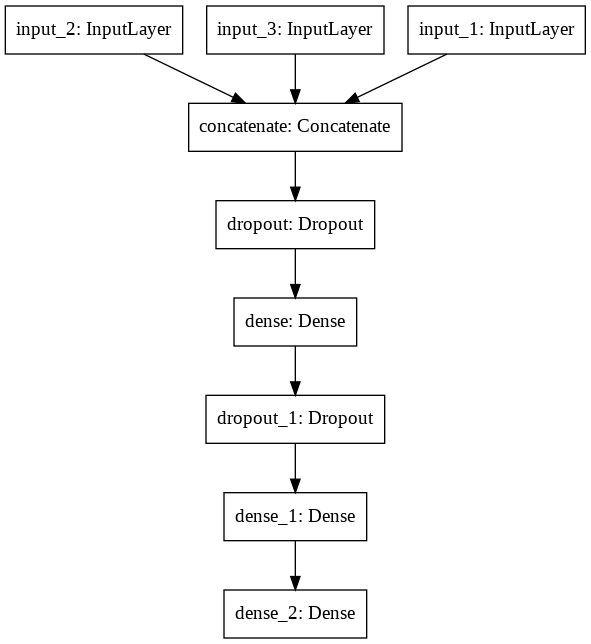

In [33]:
plot_model(model_cvec)

In [34]:
model_cvec.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [35]:
history_cvec = model_cvec.fit(x=[name_train_cvec, description_train_cvec, categorical_train_cvec.values],
                    y=y_train_cvec,
                    epochs=5,
                    verbose=True,
                    validation_data=(
                        [name_validation_cvec, description_validation_cvec, categorical_validation_cvec.values]
                        , y_validation_cvec),
                    batch_size=512)

Epoch 1/5
  67/2261 [..............................] - ETA: 5:58 - loss: 1.8163 - mse: 2388.3095 - mae: 25.9222 - root_mean_squared_error: 48.7976 - mean_squared_logarithmic_error: 3.5844 - root_mean_squared_logarithmic_error: 1.8163

KeyboardInterrupt: ignored

BOW con pulizia:
loss: 0.4549 - mse: 877.1694 - mae: 10.7754 - root_mean_squared_error: 29.6144 - mean_squared_logarithmic_error: 0.2073 - root_mean_squared_logarithmic_error: 0.4549 - val_loss: 0.4572 - val_mse: 823.4496 - val_mae: 10.7306 - val_root_mean_squared_error: 28.6958 - val_mean_squared_logarithmic_error: 0.2095 - val_root_mean_squared_logarithmic_error: 0.4573

BOW senza pulizia words:
loss: 0.4537 - mse: 892.7444 - mae: 10.7434 - root_mean_squared_error: 29.8743 - mean_squared_logarithmic_error: 0.2063 - root_mean_squared_logarithmic_error: 0.4537 - val_loss: 0.4554 - val_mse: 848.4371 - val_mae: 10.7117 - val_root_mean_squared_error: 29.1279 - val_mean_squared_logarithmic_error: 0.2079 - val_root_mean_squared_logarithmic_error: 0.4555

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    rmsle = history.history['root_mean_squared_logarithmic_error']
    val_rmsle = history.history['val_root_mean_squared_logarithmic_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(rmsle) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, rmsle, 'b', label='Training rmsle')
    plt.plot(x, val_rmsle, 'r', label='Validation rmsle')
    plt.title('Training and validation root_mean_squared_logarithmic_error')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)

### TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
tfidf_vectorizer_desc = TfidfVectorizer()
tfidf_vectorizer_desc.fit(data["item_description"].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [21]:
len(tfidf_vectorizer_desc.vocabulary_)

160142

In [22]:
tfidf_description_train = tfidf_vectorizer_desc.transform(train_cvec["item_description"].values)
tfidf_description_validation = tfidf_vectorizer_desc.transform(validation_cvec["item_description"].values)

In [23]:
tfidf_vectorizer_name = TfidfVectorizer()
tfidf_vectorizer_name.fit(data["name"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [24]:
len(tfidf_vectorizer_name.vocabulary_)

104060

In [25]:
tfidf_name_train = tfidf_vectorizer_name.transform(train_cvec["name"])
tfidf_name_validation = tfidf_vectorizer_name.transform(validation_cvec["name"])

In [26]:
tfidf_name_train

<1157452x104060 sparse matrix of type '<class 'numpy.float64'>'
	with 4876799 stored elements in Compressed Sparse Row format>

In [34]:
def getModel_bow(name_train, description_train):
    inputName = Input(name_train.shape[1])
    inputDesc = Input(description_train.shape[1])
    concat = Concatenate()([inputName, inputDesc])

    #x = Dropout(0.1)(concat)
    x = Dense(32, activation='relu')(concat)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputName ,inputDesc], outputs=x)

    return model

In [35]:
model = getModel_bow(tfidf_name_train, tfidf_description_train)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 104060)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 160142)]     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 264202)       0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           8454496     concatenate_1[0][0]        

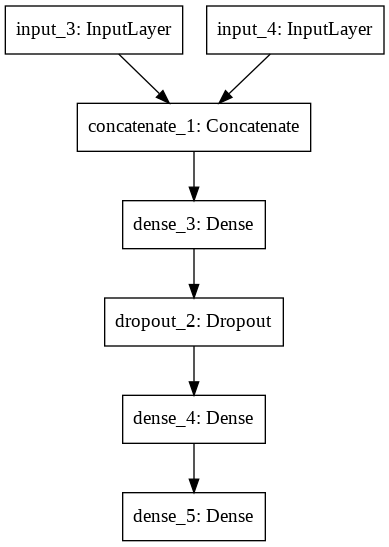

In [36]:
plot_model(model)

In [37]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [38]:
model.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:


history = model.fit(x=[tfidf_name_train, tfidf_description_train], y=y_train_cvec,
                    epochs=5,
                    verbose=True,
                    validation_data=([tfidf_name_validation, tfidf_description_validation], y_validation_cvec),
                    batch_size=512)

Epoch 1/5
2183/2261 [===========================>..] - ETA: 0s - loss: 0.9640 - mse: 1608.2288 - mae: 16.7801 - root_mean_squared_error: 40.0120 - mean_squared_logarithmic_error: 1.4004 - root_mean_squared_logarithmic_error: 0.9640

In [ ]:
prova=convert_sparse_matrix_to_sparse_tensor(tfidf_name_train)

In [53]:
type(prova)

tensorflow.python.framework.sparse_tensor.SparseTensor

In [58]:
tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(tfidf_name_train))

In [90]:
data.head(9)

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,246,1073
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,10,175
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,16,1
5,bundled items requested for ruie,3,Women/Other/Other,NA,59.0,0,"banana republic bottoms, candies skirt with ma...",53,1
6,acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,size small but straps slightly shortened to fi...,29,465
7,girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,you get three pairs of sophie cheer shorts siz...,330,896
8,girls nike pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,girls size small plus green. three shorts total.,330,3


In [93]:
data["brand_name"]

0                   NA
1                Razer
2               Target
3                   NA
4                   NA
              ...     
1482530    Free People
1482531         Disney
1482532             NA
1482533             NA
1482534             NA
Name: brand_name, Length: 1446815, dtype: string

In [92]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

dct = Dictionary(data["brand_name"].values)  # fit dictionary
corpus = [dct.doc2bow(line) for line in dataset]  # convert corpus to BoW format

model = TfidfModel(corpus)  # fit model
vector = model[corpus[0]]  # apply model to the first corpus document

TypeError: ignored

In [88]:
! pip install scipy

In [89]:
import scipy

.csr_matrix.sort_indices()

AttributeError: ignored

# Transformers

In [ ]:
pret_model_trans = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
pret_model_trans.trainable = False

tokenizer_trans = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
data = data[0:1000]

In [ ]:
train_trans, validation_trans = train_test_split(data, test_size=0.2, random_state=1000)

In [ ]:
y_train_trans = train_trans["price"]
y_train_trans

In [ ]:
y_validation_trans = validation_trans["price"]
y_validation_trans

todo: use cleaned? or let bert handle everything?

In [ ]:
inputA_train_trans = train_trans[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
inputA_validation_trans = validation_trans[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
inputName_train_trans = tokenizer_trans(train_trans["name"].to_list(),
                                  return_tensors="tf",
                                  padding=True)
#inputName_trans

In [ ]:
inputName_validation_trans = tokenizer_trans(validation_trans["name"].to_list(),
                                  return_tensors="tf",
                                  padding=True)
#inputName_trans

In [ ]:
inputName_shape_trans = (inputName_train_trans['input_ids'].shape[1],
                         inputName_train_trans['attention_mask'].shape[1])

inputName_shape_trans

In [ ]:
inputDesc_train_trans = tokenizer_trans(train_trans["item_description"].to_list(),
                                  return_tensors="tf",
                                  padding=True)

In [ ]:
inputDesc_validation_trans = tokenizer_trans(validation_trans["item_description"].to_list(),
                                  return_tensors="tf",
                                  padding=True)

In [ ]:
inputDesc_shape_trans = (inputDesc_train_trans['input_ids'].shape[1],
                         inputDesc_train_trans['attention_mask'].shape[1])
inputDesc_shape_trans

In [ ]:
def getModel_trans():
    inputA = Input(shape=(4,))
    Ad = inputA    
    
    inputName_ids = Input(shape=(inputName_shape_trans[0],), dtype='int32')
    inputName_mask = Input(shape=(inputName_shape_trans[1],), dtype='int32')

    Np = pret_model_trans(inputName_ids, attention_mask=inputName_mask)[0]

    Nd = LSTM(12,return_sequences=True)(Np)
    Nd = Flatten()(Nd)

    inputDesc_ids = Input(shape=(inputDesc_shape_trans[0],), dtype='int32')
    inputDesc_mask = Input(shape=(inputDesc_shape_trans[1],), dtype='int32')

    Dp = pret_model_trans(inputDesc_ids, attention_mask=inputDesc_mask)[0]

    Dd = LSTM(16,return_sequences=True)(Dp)
    Dd = LSTM(8,return_sequences=True)(Dd)
    Dd = Flatten()(Dd)

    concat = Concatenate()([Ad, Nd, Dd])

    x = Dropout(0.1)(concat)    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[
                          inputA,
                          inputName_ids,
                          inputName_mask,
                          inputDesc_ids,
                          inputDesc_mask
                          ], outputs=x)
    
    return model
    

In [ ]:
model_trans = getModel_trans()

In [ ]:
model_trans.summary()

In [ ]:
plot_model(model_trans)

In [ ]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return K.sqrt(msle(y_true, y_pred))

In [ ]:
model_trans.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
history_trans = model_trans.fit(x=[inputA_train_trans,
                   inputName_train_trans['input_ids'],
                   inputName_train_trans['attention_mask'],
                   inputDesc_train_trans['input_ids'],
                   inputDesc_train_trans['attention_mask']
                  ],
                   y=y_train_trans,
                    epochs=2,
                    verbose=True,
                    validation_data=([
                                      inputA_validation_trans,
                                      inputName_validation_trans['input_ids'],
                                      inputName_validation_trans['attention_mask'],
                                      inputDesc_validation_trans['input_ids'],
                                      inputDesc_validation_trans['attention_mask'],
                                      ], 
                                     y_validation_trans),
                    batch_size=512)